In [19]:
import http.client
import json
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.dates as mpl_dates
import seaborn as sns
from mpl_finance import candlestick_ohlc
import warnings
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import itertools
import missingno as msno
from sklearn.preprocessing import MinMaxScaler
import json
from sklearn.tree import plot_tree
import plotly.express as px
from sklearn.metrics import confusion_matrix



La idea es obtener la libertad financiera, no? xd

una manera es invertir en bolsa de valores, pero no sabemos cómo? veamos

primero importamos los datos de alguna empresa

In [20]:
conn = http.client.HTTPSConnection("yh-finance.p.rapidapi.com")
# Yo sé que no deben estar las credenciales acá, nomás es para aprender xd
headers = {
    'X-RapidAPI-Key': "ed509cddb7msh838134b08574d86p18893fjsn7fc06176f5c4",
    'X-RapidAPI-Host': "yh-finance.p.rapidapi.com"
}

simbolo = "AMD"
intervalo = "1d"
rango = "10y"

conn.request("GET", "/market/get-charts?symbol="+simbolo+"&interval="+intervalo+"&range="+rango, headers=headers)

res = conn.getresponse()
data = res.read()

# Convierto la respuesta JSON en un diccionario de Python
data_dict = json.loads(data.decode("utf-8"))

# Accedo a los datos
chart_data = data_dict['chart']['result'][0]

# Creamos el DataFrame con los datos relevantes
df = pd.DataFrame({
    'Timestamp': chart_data['timestamp'],
    'Open': chart_data['indicators']['quote'][0]['open'],
    'High': chart_data['indicators']['quote'][0]['high'],
    'Low': chart_data['indicators']['quote'][0]['low'],
    'Close': chart_data['indicators']['quote'][0]['close'],
    'Volume': chart_data['indicators']['quote'][0]['volume'],
})

# Convertimos la columna de 'Timestamp' a formato de fecha
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Mostramos
df.describe()

Timestamp         Open         High          Low  \
count                           2516  2516.000000  2516.000000  2516.000000   
mean   2018-09-10 20:19:51.176868096    39.718023    40.536681    38.864038   
min              2013-09-12 13:30:00     1.620000     1.690000     1.610000   
25%              2016-03-13 19:45:00     4.130000     4.200000     4.070000   
50%              2018-09-11 01:30:00    19.420000    19.975000    18.879999   
75%              2021-03-11 20:30:00    78.550003    79.809999    77.045000   
max              2023-09-11 20:00:01   163.279999   164.460007   156.100006   
std                              NaN    40.747998    41.579467    39.845343   

             Close        Volume  
count  2516.000000  2.516000e+03  
mean     39.712417  5.401572e+07  
min       1.620000  0.000000e+00  
25%       4.130000  2.693185e+07  
50%      19.400000  4.736205e+07  
75%      78.439999  7.285358e+07  
max     161.910004  3.250584e+08  
std      40.719327  3.788038e+07

In [21]:
df.tail(10)

Timestamp        Open        High         Low       Close  \
2506 2023-08-28 13:30:00  103.470001  104.070000  100.889999  102.610001   
2507 2023-08-29 13:30:00  102.110001  106.570000  101.790001  105.919998   
2508 2023-08-30 13:30:00  105.400002  107.669998  104.500000  106.589996   
2509 2023-08-31 13:30:00  106.190002  108.059998  104.860001  105.720001   
2510 2023-09-01 13:30:00  107.000000  110.059998  106.610001  109.449997   
2511 2023-09-05 13:30:00  109.000000  111.820000  106.300003  110.779999   
2512 2023-09-06 13:30:00  110.559998  111.330002  108.220001  109.279999   
2513 2023-09-07 13:30:00  106.139999  107.690002  105.089996  106.589996   
2514 2023-09-08 13:30:00  107.019997  109.739998  105.750000  106.089996   
2515 2023-09-11 20:00:01  107.315002  107.500000  103.000000  105.320000   

        Volume  
2506  55386800  
2507  50850300  
2508  54847300  
2509  58919000  
2510  54808900  
2511  66042200  
2512  47736700  
2513  49080100  
2514  46232000  
2515  50506103

Los datos por sí solos no nos dicen mucho.. Intentemos visualizarlos

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 2000x1500 with 0 Axes>

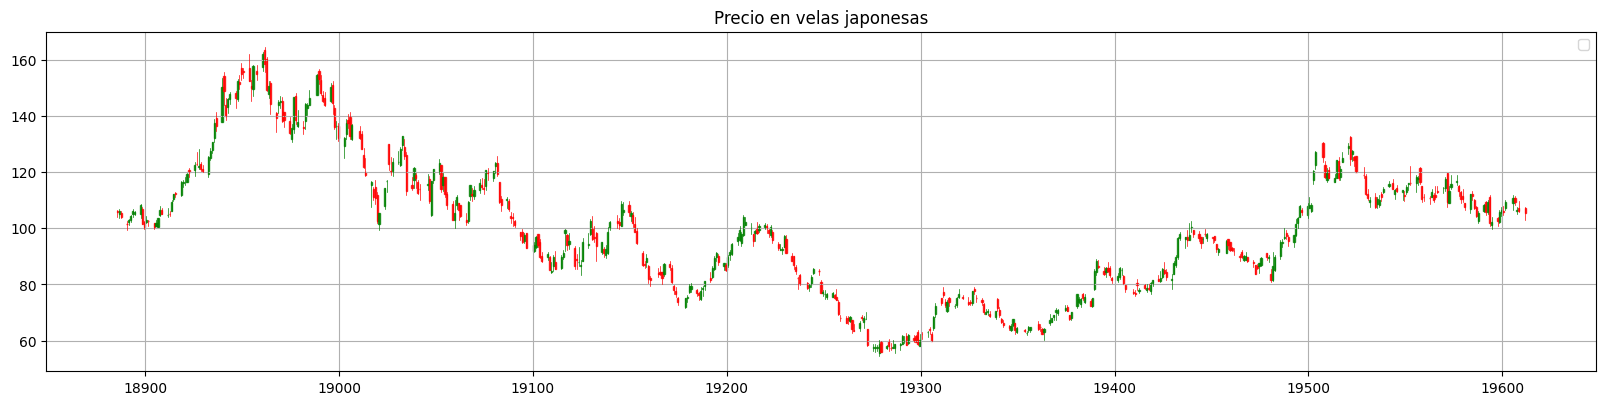

In [22]:
dataframe_sample = df.tail(500)

plt.figure(figsize=(20, 15))
ohlc = dataframe_sample.loc[:, ['Timestamp', 'Open', 'High', 'Low', 'Close']]
ohlc['Timestamp'] = pd.to_datetime(ohlc['Timestamp'])
ohlc['Timestamp'] = ohlc['Timestamp'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)
#plt.style.use('dark_background')
plt.figure(figsize=(20, 15))
price_ax = plt.subplot(3,1,3)
candlestick_ohlc(price_ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
price_ax.set_title("Precio en velas japonesas")
plt.legend()
plt.grid()



Muy lindo, no nos dice mucho. sabemos el precio y nada más. La idea es conseguir una herramienta que nos alerte de posibles entradas y salidas al mercado.. ¿Cómo?

In [23]:
# Primero vamos a necesitar algunas herramientas técnicas, pues el precio por sí solo no nos dice mucho

# un par de medias moviles exponenciales y su diferencia porcentual al precio
df['Close_EMA_20'] = (df['Close'].ewm(span=20,min_periods=20).mean())
df['Close_EMA_20_difClose'] = df['Close'] / df['Close_EMA_20']
df['Close_EMA_50'] = (df['Close'].ewm(span=50,min_periods=50).mean())
df['Close_EMA_50_difClose'] = df['Close'] / df['Close_EMA_50']
df['Close_EMA_100'] = (df['Close'].ewm(span=100,min_periods=100).mean())
df['Close_EMA_100_difClose'] = df['Close'] / df['Close_EMA_100']
df['Close_EMA_200'] = (df['Close'].ewm(span=200,min_periods=200).mean())
df['Close_EMA_200_difClose'] = df['Close'] / df['Close_EMA_200']

# el macd
df['Close_EMA_12'] = (df['Close'].ewm(span=12,min_periods=12).mean())
df['Close_EMA_26'] = (df['Close'].ewm(span=26,min_periods=26).mean())
df['MACD'] = (df['Close_EMA_12'] - df['Close_EMA_26'])
df['MACD_ant'] = ((df['MACD'].diff(periods=1) - df['MACD'])*-1)
df['MACD_senial'] = (df['MACD'].ewm(span=9,min_periods=9).mean())
df['dif_MACD_senial'] = df['MACD'] - df['MACD_senial']
df['MACD_senial_ant'] = ((df['MACD_senial'].diff(periods=1) - df['MACD_senial'])*-1)
df['MACD_histograma'] = (df['MACD'] - df['MACD_senial'])

# el rsi
delta = df['Close'].diff()
up = delta.clip(lower=0)
down = -1*delta.clip(upper=0)
df['ema_up'] = up.ewm(com=14, adjust=False).mean()
df['ema_down'] = down.ewm(com=14, adjust=False).mean()
df['RS'] = df['ema_up']/df['ema_down']
df['RSI'] = 100 - (100/(1+df['RS']))

Tal vez haga falta mostrar esas herramientas, no?

<Figure size 2000x1500 with 0 Axes>

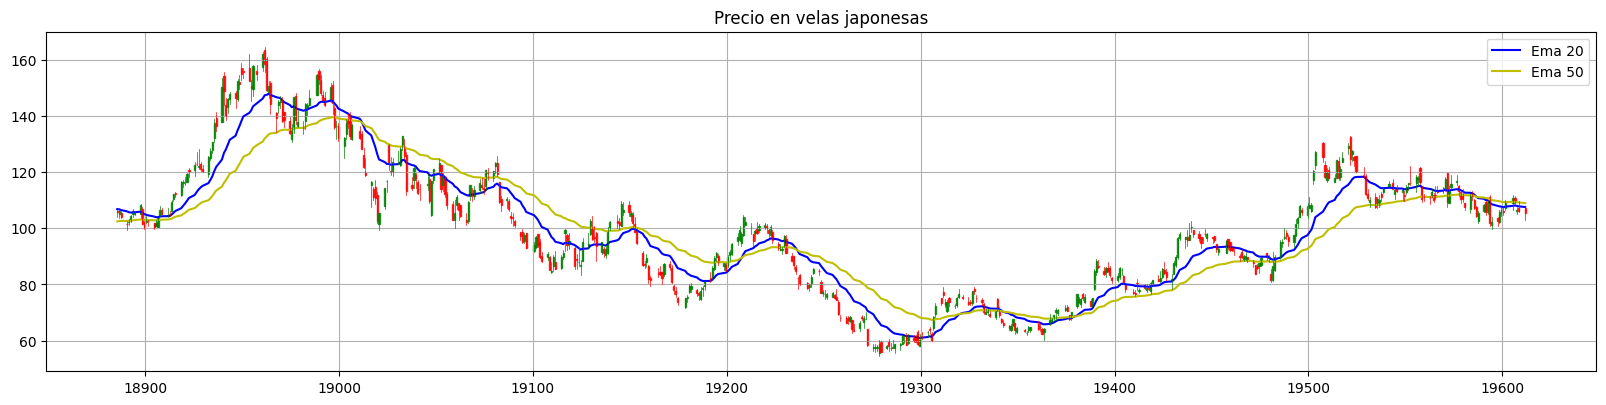

In [24]:
# Veamos algunas medias moviles

dataframe_sample = df.tail(500)
plt.figure(figsize=(20, 15))
ohlc = dataframe_sample.loc[:, ['Timestamp', 'Open', 'High', 'Low', 'Close']]
ohlc['Timestamp'] = pd.to_datetime(ohlc['Timestamp'])
ohlc['Timestamp'] = ohlc['Timestamp'].apply(mpl_dates.date2num)
ohlc = ohlc.astype(float)
#plt.style.use('dark_background')
plt.figure(figsize=(20, 15))
price_ax = plt.subplot(3,1,3)
plt.plot(ohlc['Timestamp'],dataframe_sample['Close_EMA_20'], label='Ema 20', color = "b")
plt.plot(ohlc['Timestamp'],dataframe_sample['Close_EMA_50'], label='Ema 50', color = "y")
candlestick_ohlc(price_ax, ohlc.values, width=0.6, colorup='green', colordown='red', alpha=0.8)
price_ax.set_title("Precio en velas japonesas")
plt.legend()
plt.grid()



A simple vista podemos interpretar que si la ema corta (de 20) está sobre la larga (50) el precio va al alza, es un buen punto de inicio. Pero nosotros queremos más!

Veamos las otras herramientas

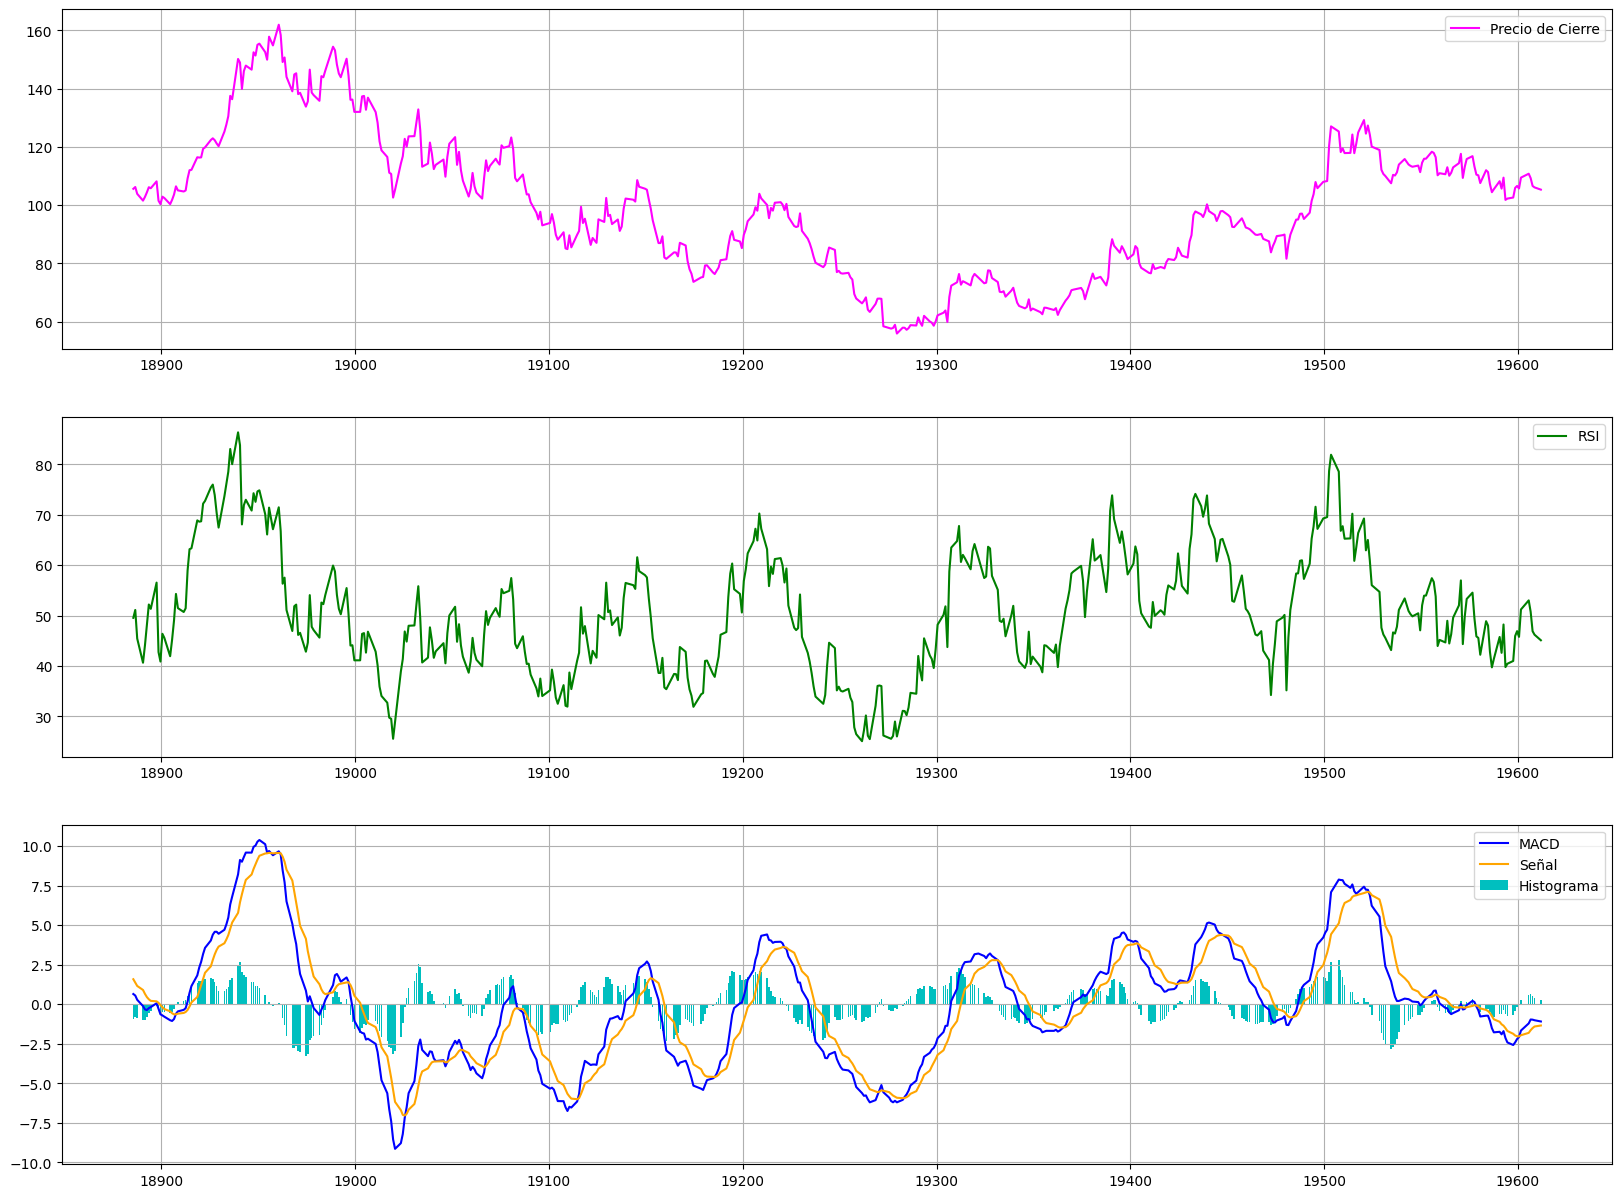

In [25]:
# Configuración del tamaño de la figura
plt.figure(figsize=(20, 15))

# Primer subgráfico para MACD
ax1 = plt.subplot(3, 1, 3)
plt.plot(ohlc['Timestamp'], dataframe_sample['MACD'], label="MACD", color="b")
plt.plot(ohlc['Timestamp'], dataframe_sample['MACD_senial'], label="Señal", color="orange")
plt.bar(ohlc['Timestamp'], dataframe_sample['MACD_histograma'], label="Histograma", color="c")
plt.legend()
plt.grid()

# Segundo subgráfico para RSI
ax2 = plt.subplot(3, 1, 2, sharex=ax1)
plt.plot(ohlc['Timestamp'], dataframe_sample['RSI'], label="RSI", color="g")
plt.legend()
plt.grid()

# Tercer subgráfico para el precio de cierre
ax3 = plt.subplot(3, 1, 1, sharex=ax1)
plt.plot(ohlc['Timestamp'], dataframe_sample['Close'], label="Precio de Cierre", color="magenta")
plt.legend()
plt.grid()



# Mostrar la figura completa
plt.show()


Una vez más, a simple vista podemos apreciar que cuando el precio está al alza, el RSI está sobre la linea de 50, más allá de que esté saturado o no. El MACD por su lado también tiene sus cuestiones, si el MACD está SOBRE la señal, es porque el gráfico está al alza, y cuando vemos una disminución en el histograma, que está cambiando de dirección, tenemos una próxima reversión de tendencia (al margen de las convergencias y divergencias que es para lo que está desarrollada la herramienta, esto se aprecia a simple vista)

La idea, de todas formas, es tener algo, un semáforo que nos advierta más simplemente de comprar o vender un activo, no?

Intentemos con Machine Learning

In [26]:
# Primero crearemos nuestra variable objetivo, para ello sacamos la diferencia porcentual del precio
# de cierre con los 20 días posteriores (esto es imposible en la realidad, pero para procesar los datos
# está bien)
df['Retorno'] = df['Close'].pct_change(20).shift(-20)

# Y agregamos las señales de la varaible objetivo. Acá determinamos una "señal de compra o venta"
# en base a un retorno esperado del 15% y una caída esperada del 5%
_retorno = 0.25 # Vamos a suponer que buscamos las posiciones donde el retorno será mayor a 15%
_drawdown = -0.10 # Determinamos una caída máxima para evitar señales falsas


for pos in range(len(df)):  
    desde = pos
    # Para cada iteración, guardamos las posiciones, rangos, donde deberemos buscar el drawdown
    if pos + 20 > df.shape[0]:
        hasta = df.shape[0]
    else:
        hasta = pos + 20 # es 20 porque determinamos una dif diaria del precio de 20 días
    
    # Esta linea determina el % minimo al que ha caido entre los rangos que está procesando. 
    # Buscamos señales sin caídas en el medio, un objetivo a 20 días con ganancias de 15% puede
    # tener una caída de 20% en medio y una subida de 35%
    min_for_drawdown = df.iloc[desde:hasta]['Retorno'].min()
    
    # Si el retorno es mayor al esperado y no hay una caída mayor a la determinada entonces:
    # señal de compra '1'
    if pos >= 3 and df.iloc[pos]['Retorno'] > _retorno and min_for_drawdown > _drawdown:
        df.at[pos,'senial'] = 1
    # Sino, si el retorno es menor a la ganancia esperada negativa, es señal de venta
    elif pos >= 3 and df.iloc[pos]['Retorno'] < _retorno*-1:
        df.at[pos,'senial'] = -1


In [27]:
# Veamos cómo quedó nuestra señal para el entrenamiento

df['senial'].value_counts() # Aca vemos la cantidad de señales de compra, venta y hold


senial
 1.0    200
-1.0     67
Name: count, dtype: int64

In [28]:
# Reescalamos los features, así ML trabajará mejor
scaler = MinMaxScaler(feature_range=(-1, 1))
df['Close_EMA_20_difClose_scaled'] = scaler.fit_transform(df[['Close_EMA_20_difClose']])
df['Close_EMA_50_difClose_scaled'] = scaler.fit_transform(df[['Close_EMA_50_difClose']])
df['Close_EMA_100_difClose_scaled'] = scaler.fit_transform(df[['Close_EMA_100_difClose']])
df['Close_EMA_200_difClose_scaled'] = scaler.fit_transform(df[['Close_EMA_200_difClose']])
df['MACD_scaled'] = scaler.fit_transform(df[['MACD']])
df['MACD_ant_scaled'] = scaler.fit_transform(df[['MACD_ant']])
df['MACD_senial_scaled'] = scaler.fit_transform(df[['MACD_senial']])
df['dif_MACD_senial_scaled'] = scaler.fit_transform(df[['dif_MACD_senial']])
df['MACD_senial_ant_scaled'] = scaler.fit_transform(df[['MACD_senial_ant']])
df['MACD_histograma_scaled'] = scaler.fit_transform(df[['MACD_histograma']])
df['RSI_scaled'] = scaler.fit_transform(df[['RSI']])

In [29]:
# Los listamos para entrenar, la idea es tener una lista de combinaciones. Como no sabemos cuáles son los mejores features, iteraremos por todos (alto nivel computacional)
list_of_features = [
    'RSI_scaled',
    'MACD_histograma_scaled',
    'MACD_senial_ant_scaled',
    'dif_MACD_senial_scaled',
    'MACD_senial_scaled',
    'MACD_ant_scaled',
    'MACD_scaled',
    'Close_EMA_200_difClose_scaled',
    'Close_EMA_100_difClose_scaled',
    'Close_EMA_50_difClose_scaled',
    'Close_EMA_20_difClose_scaled',
]

# En base a la lista de features se hará un trabajo de combinación para tener todas las posibles combinatorias de features
combinations = []
for r in range(len(list_of_features)+1):
    for combination in itertools.combinations(list_of_features, r):
        combinations.append(combination)
largo_combinations = len(combinations)
combinations = list(combinations)
print("Hay", largo_combinations,"combinaciones de features distintas")

Hay 2048 combinaciones de features distintas


Interesante cantidad de combinaciones con tan pocas herramientas técnicas, es menester considerar que mientras más complejo, más poder computacional será necesario y/o tardará más.

<Axes: >

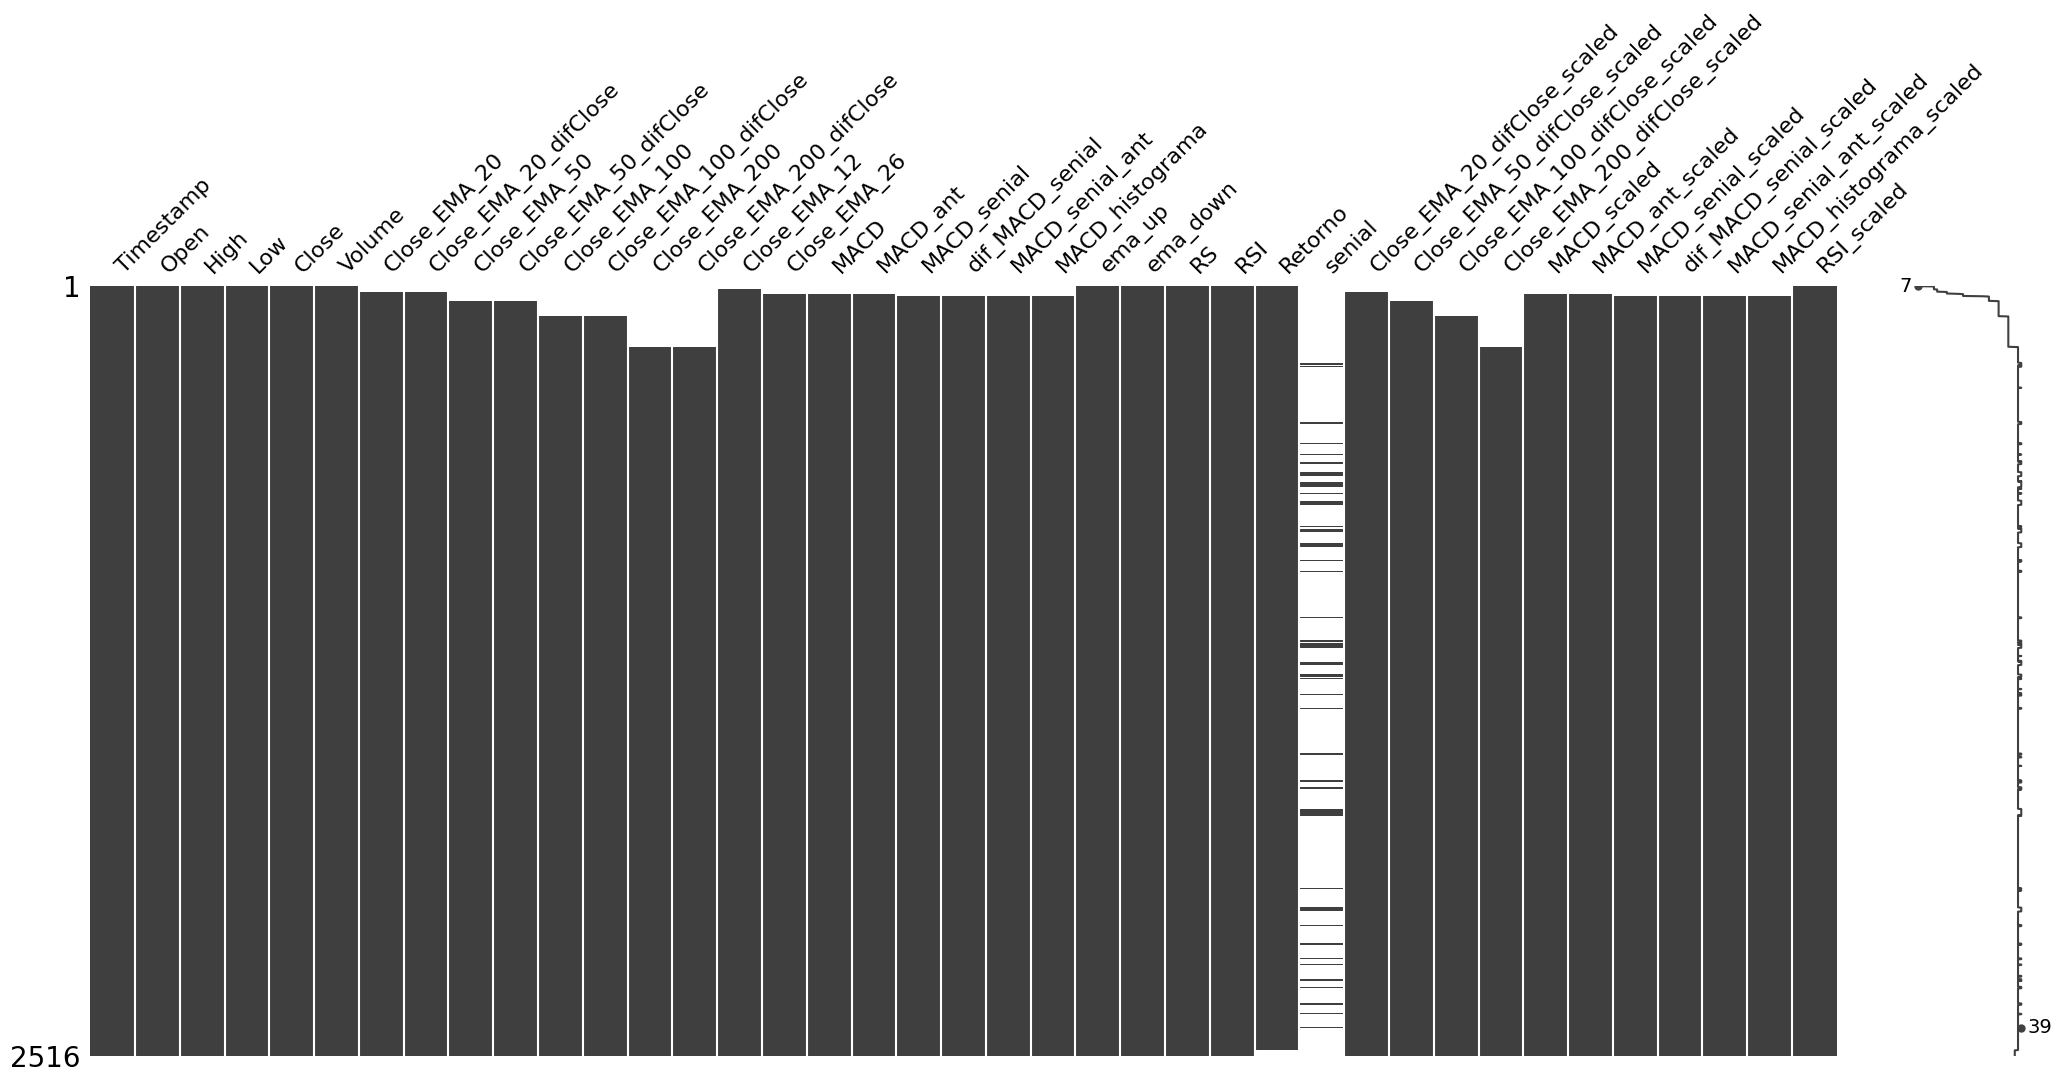

In [30]:
# veamos ahora los valores nulos
msno.matrix(df)


No es muy alentador pero podemos descartar los valores nulos, ya que la idea es entrenar modelos para detectar las señales de compra y venta 

<Axes: >

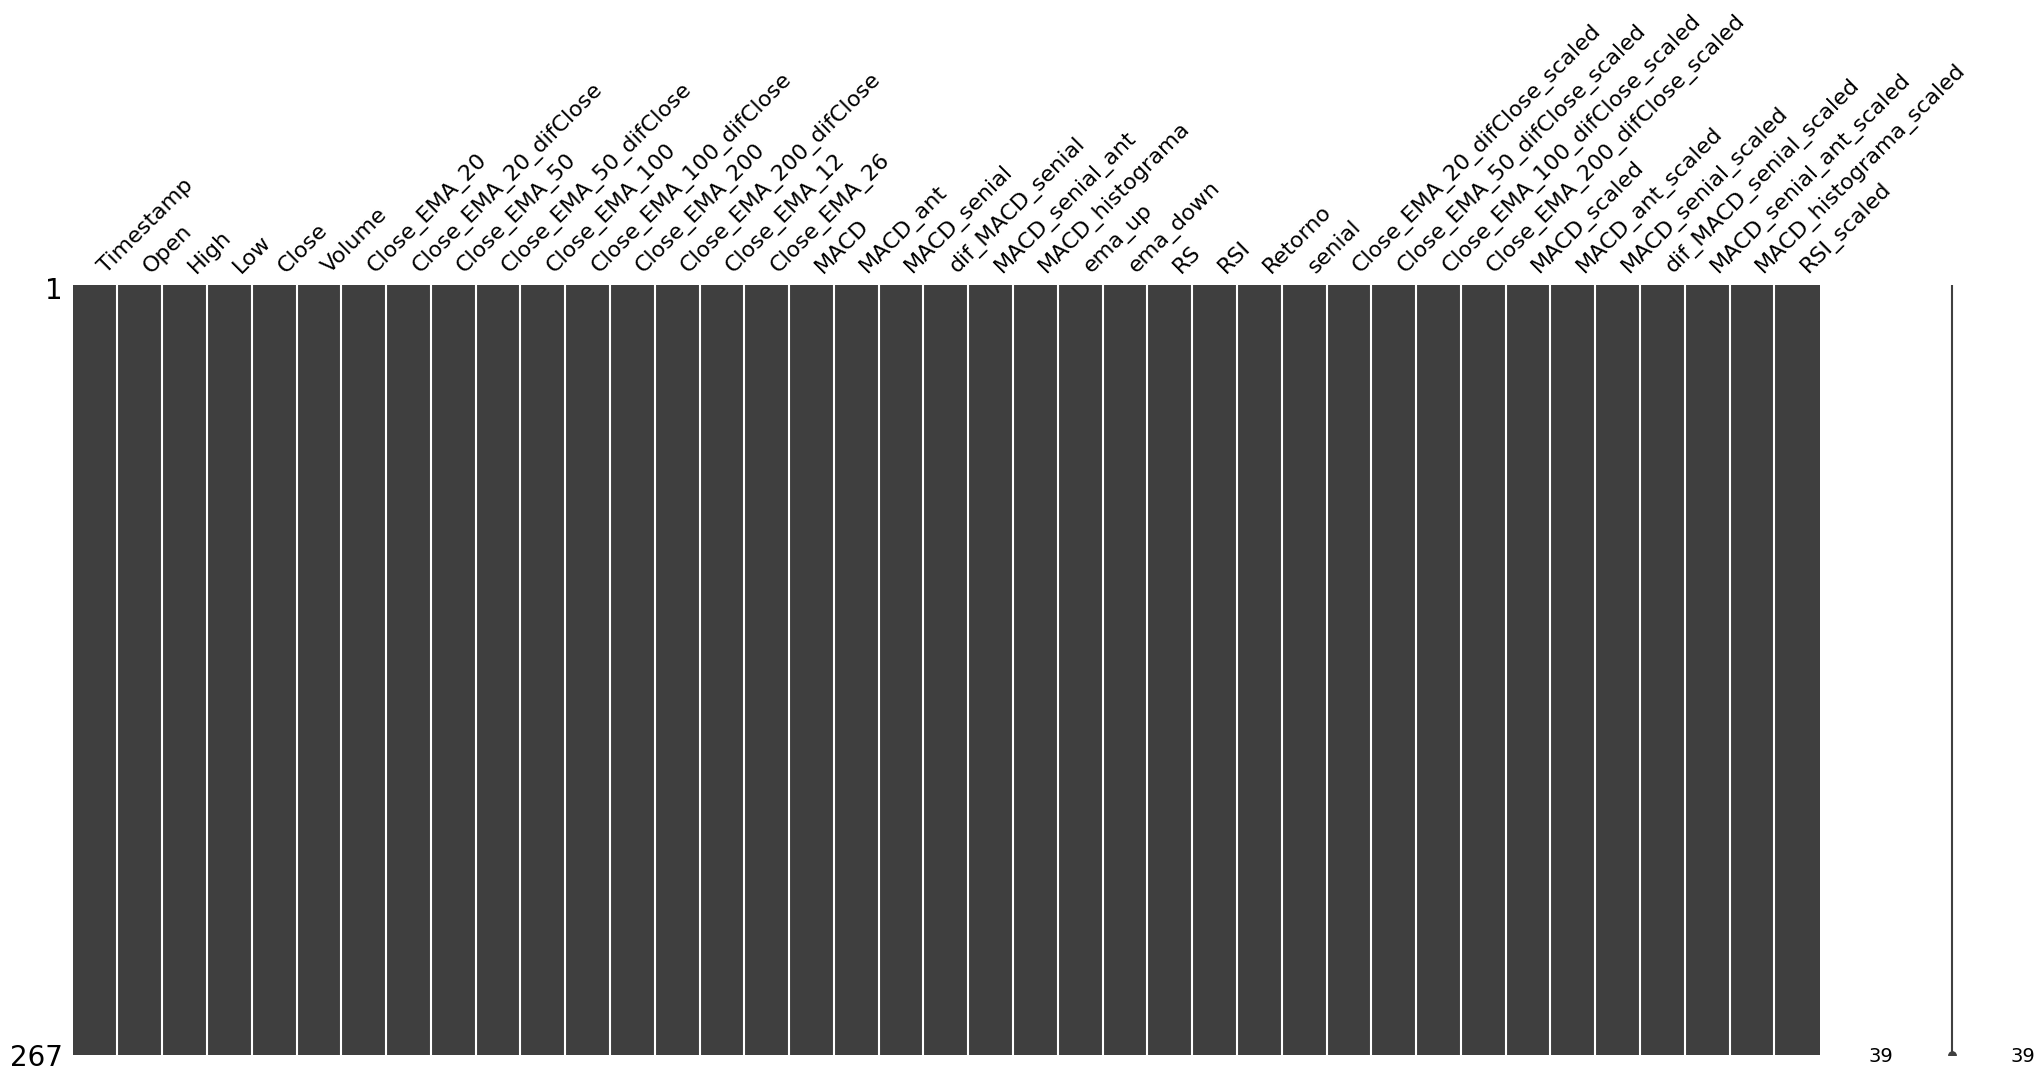

In [31]:
df_wo_na = df.dropna() # borramos los datos nulos y chequeamos nuevamente
msno.matrix(df_wo_na)


Intentaremos crear un modelo para clasificar esas señales de entrada o salida, intentaremos predecirlos con esa clasificación

In [32]:

precision_1 = 0
recall = 0
f1_score = 0
support_1 = 0
precision_1_n = 0
recall_n = 0
f1_score_n = 0
support_1_n = 0      
accuracy = 0
precision_macro_avg = 0
recall_macro_avg = 0
f1_score_macro_avg = 0
support_1_macro_avg = 0       
precision_weighted_avg = 0
recall_weighted_avg = 0
f1_score_weighted_avg = 0
support_1_weighted_avg = 0  
#--
precision_1_f = 0
recall_f = 0
f1_score_f = 0
support_1_f = 0
precision_1_n_f = 0
recall_n_f = 0
f1_score_n_f = 0
support_1_n_f = 0      
accuracy_f = 0
precision_macro_avg_f = 0
recall_macro_avg_f = 0
f1_score_macro_avg_f = 0
support_1_macro_avg_f = 0       
precision_weighted_avg_f = 0
recall_weighted_avg_f = 0
f1_score_weighted_avg_f = 0
support_1_weighted_avg_f = 0

best_model = None
best_report = ""
best_features = ""

dict_con_todo  = {}

#df_wo_na es el dataframe sin nulos

for feature in combinations: #Iterará entre todos los features creando modelos para cada caso
    if len(feature)>0:
        X = df_wo_na[list(feature)]
        y = df_wo_na['senial']
        X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3) 
        #treeClassifier = DecisionTreeClassifier(max_depth=10) # max_depth=6,min_samples_leaf=7
        treeClassifier = DecisionTreeClassifier(max_depth=6,min_samples_leaf=7) # max_depth=6,min_samples_leaf=7
        treeClassifier.fit(X_train,y_train)
        y_pred = treeClassifier.predict(X_test)
        report = classification_report(y_test,y_pred , output_dict=True)
        
        # guardamos el reporte y los features en un diccionario simple
        dict_nuevo = {
            str(feature) : report,
        }   
        dict_con_todo.update(dict_nuevo)

        # Guardo el contenido del diccionario del reporte en variables
        precision_1 = report.get('1.0',{'dictionary':0}).get('precision',0)
        recall = report.get('1.0',{'dictionary':0}).get('recall',0)
        f1_score = report.get('1.0',{'dictionary':0}).get('f1-score',0)
        support_1 = report.get('1.0',{'dictionary':0}).get('support',0)
        precision_1_n = report.get('1.0',{'dictionary':0}).get('precision',0)
        recall_n = report.get('1.0',{'dictionary':0}).get('recall',0)
        f1_score_n = report.get('1.0',{'dictionary':0}).get('f1-score',0)
        support_1_n = report.get('1.0',{'dictionary':0}).get('support',0)        
        accuracy = report.get('accuracy',0)
        precision_macro_avg = report.get('macro avg',{'dictionary':0}).get('precision',0)
        recall_macro_avg = report.get('macro avg',{'dictionary':0}).get('recall',0)
        f1_score_macro_avg = report.get('macro avg',{'dictionary':0}).get('f1-score',0)
        support_1_macro_avg = report.get('macro avg',{'dictionary':0}).get('support',0)        
        precision_weighted_avg = report.get('weighted avg',{'dictionary':0}).get('precision',0)
        recall_weighted_avg = report.get('weighted avg',{'dictionary':0}).get('recall',0)
        f1_score_weighted_avg = report.get('weighted avg',{'dictionary':0}).get('f1-score',0)
        support_1_weighted_avg = report.get('weighted avg',{'dictionary':0}).get('support',0)    
        
        # Jugando un poco con el diccionario de reporte, decidí comparar los f1 score y el accuracy para buscar el mejor
        
        if (
            f1_score > f1_score_f 
            and f1_score_n > f1_score_n_f 
            and accuracy > accuracy_f 
            and f1_score_macro_avg > f1_score_macro_avg_f 
            and f1_score_weighted_avg > f1_score_weighted_avg_f
        ):
            f1_score_f = f1_score
            f1_score_n_f = f1_score_n
            accuracy_f = accuracy
            f1_score_macro_avg_f = f1_score_macro_avg 
            f1_score_weighted_avg_f = f1_score_weighted_avg
            best_model = treeClassifier
            best_report = report
            best_features = feature
            para_mostrar = json.dumps(best_report, indent=4)
            print("Se encontró una mejor combinación \n features:",best_features,"\n", para_mostrar)

Se encontró una mejor combinación 
 features: ('RSI_scaled',) 
 {
    "-1.0": {
        "precision": 0.6923076923076923,
        "recall": 0.4090909090909091,
        "f1-score": 0.5142857142857142,
        "support": 22.0
    },
    "1.0": {
        "precision": 0.8088235294117647,
        "recall": 0.9322033898305084,
        "f1-score": 0.8661417322834646,
        "support": 59.0
    },
    "accuracy": 0.7901234567901234,
    "macro avg": {
        "precision": 0.7505656108597285,
        "recall": 0.6706471494607088,
        "f1-score": 0.6902137232845894,
        "support": 81.0
    },
    "weighted avg": {
        "precision": 0.7771772526674486,
        "recall": 0.7901234567901234,
        "f1-score": 0.7705759002346928,
        "support": 81.0
    }
}
Se encontró una mejor combinación 
 features: ('dif_MACD_senial_scaled',) 
 {
    "-1.0": {
        "precision": 0.5333333333333333,
        "recall": 0.5333333333333333,
        "f1-score": 0.5333333333333333,
        "support":

In [33]:
report_str = json.dumps(best_report, indent=4)
print("el MEJOR reporte es\n",report_str, "\n\ncon los siguientes features:",best_features, "longitud features:", len(best_features))

el MEJOR reporte es
 {
    "-1.0": {
        "precision": 0.7894736842105263,
        "recall": 0.8823529411764706,
        "f1-score": 0.8333333333333333,
        "support": 17.0
    },
    "1.0": {
        "precision": 0.967741935483871,
        "recall": 0.9375,
        "f1-score": 0.9523809523809523,
        "support": 64.0
    },
    "accuracy": 0.9259259259259259,
    "macro avg": {
        "precision": 0.8786078098471987,
        "recall": 0.9099264705882353,
        "f1-score": 0.8928571428571428,
        "support": 81.0
    },
    "weighted avg": {
        "precision": 0.9303276111425517,
        "recall": 0.9259259259259259,
        "f1-score": 0.9273956496178719,
        "support": 81.0
    }
} 

con los siguientes features: ('RSI_scaled', 'MACD_histograma_scaled', 'MACD_senial_scaled', 'MACD_scaled', 'Close_EMA_200_difClose_scaled', 'Close_EMA_100_difClose_scaled') longitud features: 6


Ya tenemos un modelo entrenado, intentaremos visualizar su estructura (solo a modo informativo)

In [34]:
if best_model is not None:
    fig, ax = plt.subplots(figsize=(20, 10), dpi=1100)
    plot_tree(best_model, filled=True, feature_names=list(best_features), class_names=['0', '1'], rounded=True, ax=ax)
    
    for annotation in ax.get_children():
        if isinstance(annotation, plt.Text):
            annotation.set_color('black')
    
    plt.savefig('high_res_tree.png', format='png', dpi=1100)
    plt.savefig('high_res_tree.svg', format='svg')
    plt.show()


Esto no nos dice mucho más que la estructura que machine learning encontró, intentemos visualizar las predicciones en el dataframe y contrastarlas con la señal real impuesta por nosotros

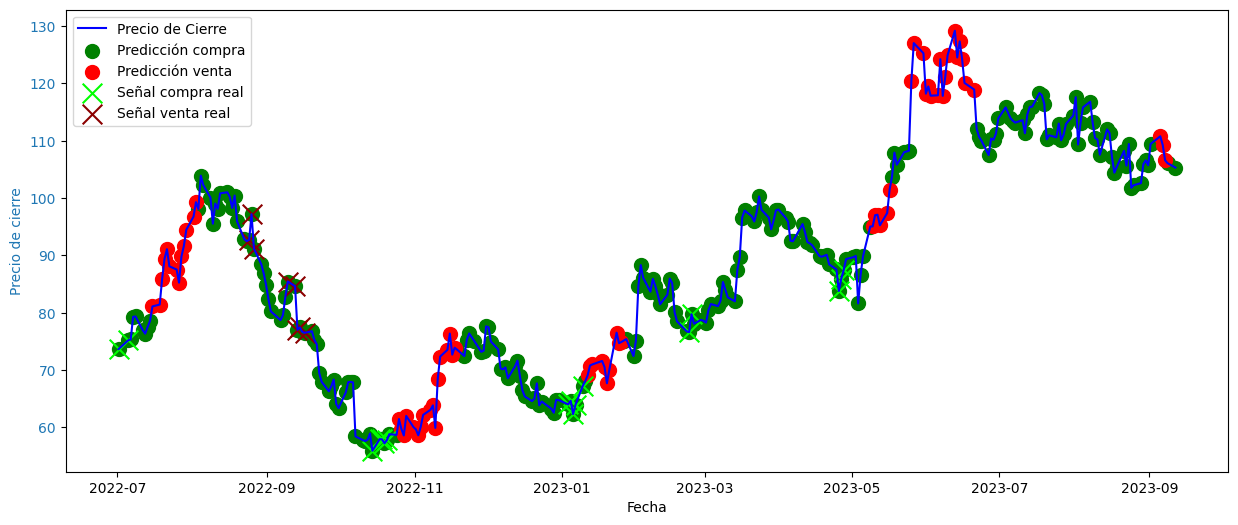

In [35]:

df['prediccion'] = best_model.predict(df[list(best_features)])

df2 = df.tail(300)

fig, ax1 = plt.subplots(figsize=(15, 6))
ax1.plot(df2['Timestamp'], df2['Close'], color='#0000FF', label='Precio de Cierre')

ax1.set_xlabel('Fecha')
ax1.set_ylabel('Precio de cierre', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1.scatter(df2['Timestamp'][df2['prediccion'] == 1], df2['Close'][df2['prediccion'] == 1], color='green', s=100, marker='o', label='Predicción compra')
ax1.scatter(df2['Timestamp'][df2['prediccion'] == -1], df2['Close'][df2['prediccion'] == -1], color='red', s=100, marker='o', label='Predicción venta')
ax1.scatter(df2['Timestamp'][df2['senial'] == 1], df2['Close'][df2['senial'] == 1], color='lime', s=200, marker='x', label='Señal compra real')
ax1.scatter(df2['Timestamp'][df2['senial'] == -1], df2['Close'][df2['senial'] == -1], color='darkred', s=200, marker='x', label='Señal venta real')

ax1.legend(loc='best')

plt.show()


En el grafico podemos apreciar la realidad contra la predicción. Recordemos que las señales de compra y venta reales (las cruces) son la variación del precio futuro en 20 días, y la predicción (los círculos) intenta acercarse a esas señales. 
Si bien esto es un preliminar se puede apreciar un acierto interesante, de haber considerado estas señales hubieramos obtenido profit considerables

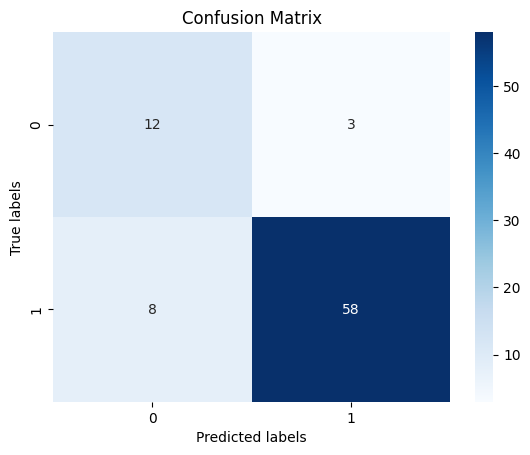

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()